## Cetacean Photogrammetry API

This API allows a user to upload aerial images of whales and they will be identified by species and photogrammetrically measured.

Currently the model is trained on humpback, blue, and minke whales.

In [1]:
# bring in necessary python modules
import os
import io
import sys
import json
import requests
import matplotlib.pyplot as plt
from PIL import Image

# This keeps the notebook clean, without the previous results being cached.  
%autosave 0


# URLs for checking API health and predicting whale species and length
API_HEALTH_URL = 'http://photogramapi.eastus.azurecontainer.io'
API_URL = 'http://photogramapi.eastus.azurecontainer.io/v1/cetacean_photogram/predict/'

Autosave disabled


### Utility Functions

In [2]:
def get_image(img_url):
    image_data = requests.get(img_url) 
    return image_data.content
    
def get_pil_image(img):
    return(Image.open(io.BytesIO(img)))

def health_check():
    try:           
        r = requests.get(API_HEALTH_URL)
        
        if r.status_code == requests.codes.ok:
            return r.json()
        else:
            return None

    except Exception as e:
        print('Exception running API: {}'.format(e))
        
def measure_image(image_url):
    try:           
        r = requests.post(API_URL, data = get_image(image_url))        

        if r.status_code == requests.codes.ok:
            return r.json()
        else:
            return None

    except Exception as e:
        print('Exception running API: {}'.format(e))

These functions require some attributes about how the imagery was acquired in order to convert from pixel lengths to real world lengths. 

In [3]:
def pixel_to_meters(pixels, pixel_size, focal_length, total_altitude):
    return(pixels * pixel_size/focal_length * total_altitude)

def convert_measurements(pixel_length, pixel_size, focal_length, altitude, org_img_size=(6000.0, 4000.0)):
    all_lengths = []
    
    converted_length = pixel_to_meters(pixel_length, pixel_size, focal_length, altitude)   
        
    return(converted_length)

### Image Metadata

In [4]:
sample_data = [{
    'url' : 'https://github.com/patrickcgray/cetacean_photogram_api/blob/master/data/DSC01506.JPG?raw=true',
    'altitude' : 68.0054,
    'focal_length' : 5,
    'pixel_size' : 0.000392,
    'whales' : [{'species' : 'Humpback', 'ground_truth_length' : 10.17}]},
    {
    'url' : 'https://github.com/patrickcgray/cetacean_photogram_api/blob/master/data/DSC03331.JPG?raw=true',
    'altitude' : 74.5408,
    'focal_length' : 5,
    'pixel_size' : 0.000392,
    'whales' : [{'species' : 'Blue', 'ground_truth_length' : 22.16}]},
    {
    'url' : 'https://github.com/patrickcgray/cetacean_photogram_api/blob/master/data/DSC09070.JPG?raw=true',
    'altitude' : 77.5000,
    'focal_length' : 5,
    'pixel_size' : 0.000392,
    'whales' : [{'species' : 'Minke', 'ground_truth_length' : 8.261536}]}
]

### Inspect the data

Check out the imagery data we're using. Let's loop through the images from sample_data.

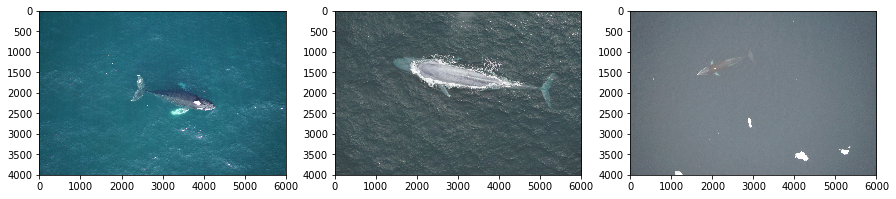

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8)) 

for i, image in enumerate(sample_data):
    sample_image_url = image['url']
    test_image = get_image(sample_image_url)
    img = get_pil_image(test_image)
    axs[i].imshow(img)

### API Calls

First, make sure the API is up and running

In [6]:
result = health_check()
print(result)

{'health': 'OK'}


#### Predict!

Finally let's use the API to get predictions on each image and compare automated species and length predictions to manually generated validation data.

In [7]:
for image in sample_data:
    response = measure_image(image['url'])
    print("Detections:")
    for detection in response:
        print("\t", detection['species'], 
              convert_measurements(detection['length (pixels)'], image['pixel_size'], 
                         image['focal_length'], image['altitude']))
    print('Validation Data:')
    for whale in image['whales']:
        print("\t", whale['species'], whale['ground_truth_length'])
    print('---')

Detections:
	 Humpback 10.710302204877431
Validation Data:
	 Humpback 10.17
---
Detections:
	 Blue 21.778467083005562
Validation Data:
	 Blue 22.16
---
Detections:
	 Minke 8.419551345897547
Validation Data:
	 Minke 8.261536
---
